In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Should increase beta to =0.1 for stability

In [164]:
dt = 0.04
noise_var = 12
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2500,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100
)
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1.,
        solver_settings=optsettings,
        fixed_colloc_weight=50.,
        fixed_data_weight=1.,
        max_inner_iterations=500,
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(11.66083277, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 50.0}
Warm Start


  0%|          | 0/2500 [00:00<?, ?it/s]

Iteration 0, loss = 1.375e+06, gradnorm = 2.387e+09, alpha = 4.167, improvement_ratio = 0.9366
Iteration 1, loss = 2.128e+05, gradnorm = 4.825e+09, alpha = 3.472, improvement_ratio = 0.8485
Iteration 2, loss = 3.697e+04, gradnorm = 8.963e+08, alpha = 2.894, improvement_ratio = 0.8462
Iteration 3, loss = 1.53e+04, gradnorm = 3.469e+08, alpha = 2.894, improvement_ratio = 0.675
Iteration 4, loss = 5.323e+03, gradnorm = 3.672e+08, alpha = 2.411, improvement_ratio = 0.9495
Iteration 5, loss = 4.976e+03, gradnorm = 1.024e+08, alpha = 2.411, improvement_ratio = 0.606
Line Search Failed!
Final Iteration Results
Iteration 47, loss = 4.696e+03, gradnorm = 0.01304, alpha = 58.37, improvement_ratio = -6.05
Model after smooth warm start
(x)' = 0.057 1 + -3.010 x + 5.392 y + 0.213 z + 0.669 x^2 + -0.638 x y + -0.272 x z + 0.172 y^2 + 0.236 y z + -0.036 z^2
(y)' = 0.199 1 + 12.549 x + 6.784 y + -1.830 z + -0.926 x^2 + 1.152 x y + -0.511 x z + -0.394 y^2 + -0.227 y z + 0.100 z^2
(z)' = -0.654 1 + 2.60

In [165]:
metrics

{'coeff_mets': {'precision': 0.6,
  'recall': 0.8571428571428571,
  'f1': 0.7058823529411765,
  'coeff_rel_l2': 0.6147968150404779,
  'coeff_rmse': 3.5390642373240797,
  'coeff_mae': 0.9827261734182303},
 'data_mets': {'mse': Array(108.33531135, dtype=float64),
  'rmse': np.float64(10.408425017680944),
  'mae': np.float64(6.6733670944977765),
  'max_abs_error': np.float64(59.83272265507293),
  'normalized_mse': Array(0.02784723, dtype=float64),
  'relative_l2_error': np.float64(0.16684827412153638)},
 'model_params': {'show_progress': True,
  'sigma2_est': Array(11.66083277, dtype=float64),
  'data_weight': 1.0,
  'colloc_weight': 50.0}}

In [166]:
model.print()

(x)' = -12.296 x + 12.940 y
(y)' = 26.835 x + -0.757 y + -0.959 x z
(z)' = 18.896 1 + 0.907 x + -3.698 z + 0.516 x^2 + 0.446 y^2


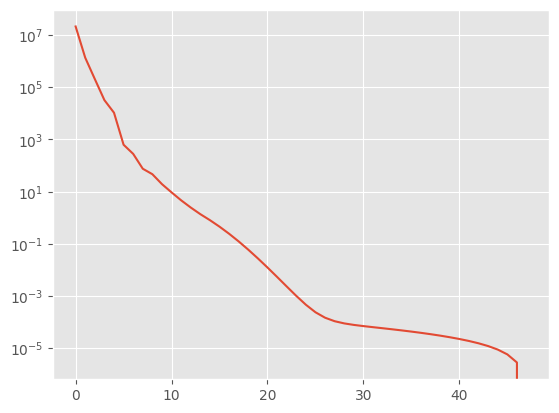

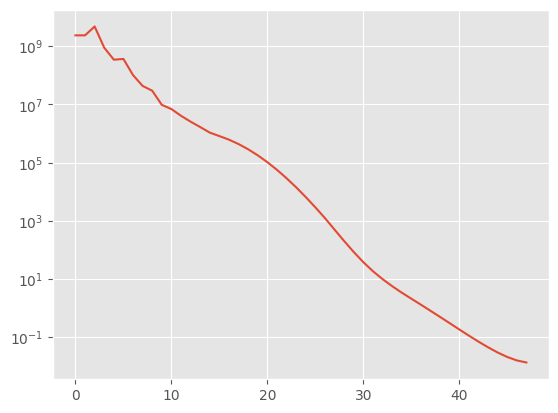

In [171]:
opt = model.opt_result[0]
plt.plot(opt.loss_vals - opt.loss_vals[-1])
plt.yscale('log')
plt.show()
plt.plot(opt.gradnorm)
plt.yscale('log')
plt.show()

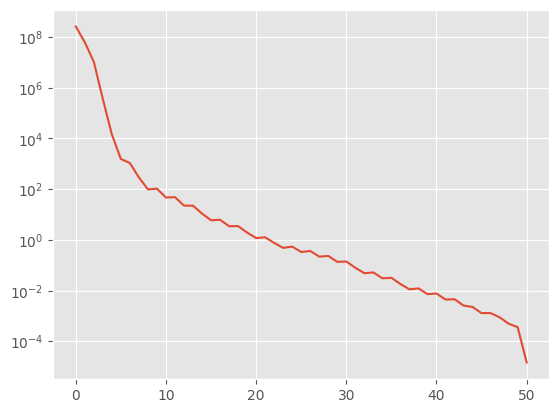

In [172]:
opt = model.opt_result[1]
plt.plot(opt.history['gnorms'][0])
plt.yscale('log')

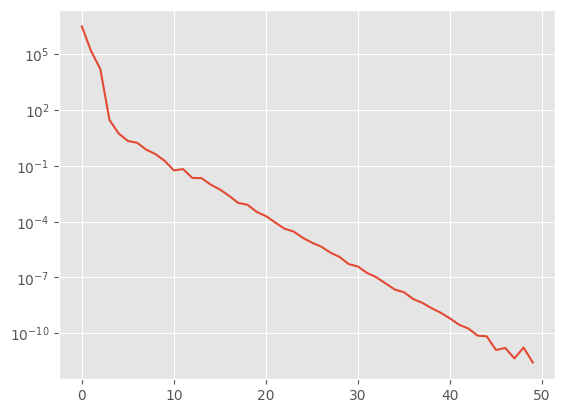

In [173]:
step_index = 0
plt.plot(-1*jnp.diff(jnp.array(opt.history['objval'][step_index])))
plt.yscale('log')

In [174]:
metrics

{'coeff_mets': {'precision': 0.6,
  'recall': 0.8571428571428571,
  'f1': 0.7058823529411765,
  'coeff_rel_l2': 0.6147968150404779,
  'coeff_rmse': 3.5390642373240797,
  'coeff_mae': 0.9827261734182303},
 'data_mets': {'mse': Array(108.33531135, dtype=float64),
  'rmse': np.float64(10.408425017680944),
  'mae': np.float64(6.6733670944977765),
  'max_abs_error': np.float64(59.83272265507293),
  'normalized_mse': Array(0.02784723, dtype=float64),
  'relative_l2_error': np.float64(0.16684827412153638)},
 'model_params': {'show_progress': True,
  'sigma2_est': Array(11.66083277, dtype=float64),
  'data_weight': 1.0,
  'colloc_weight': 50.0}}

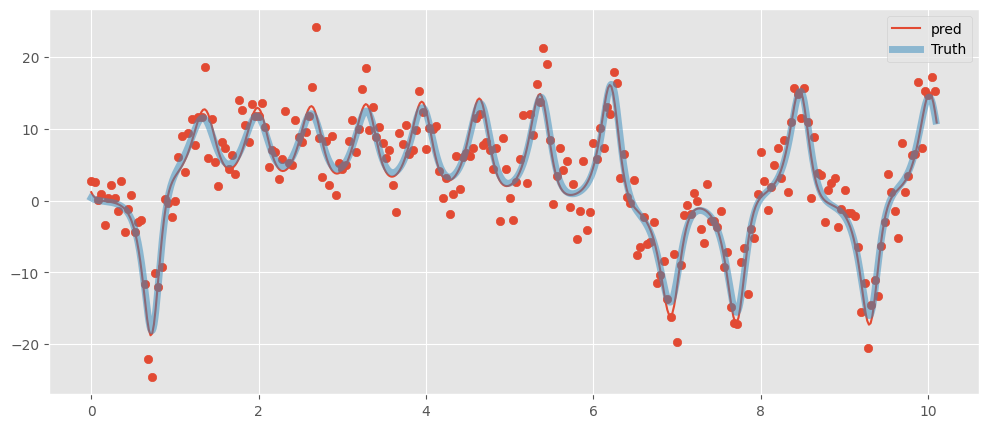

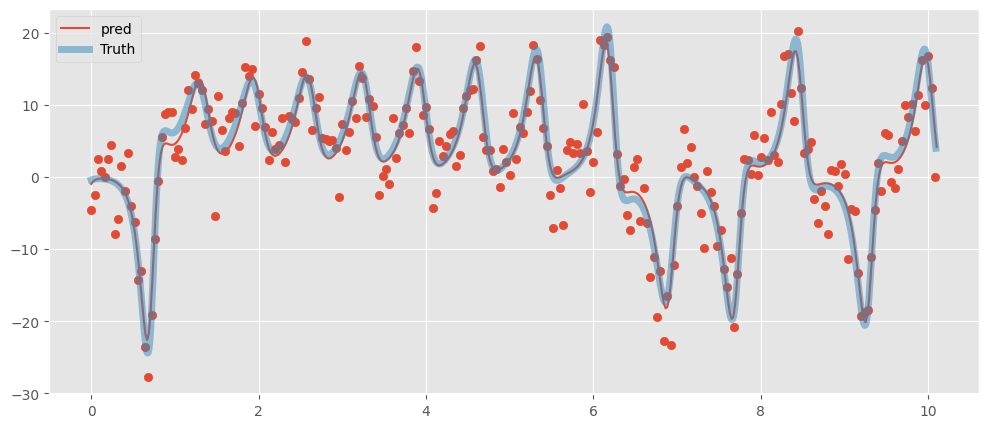

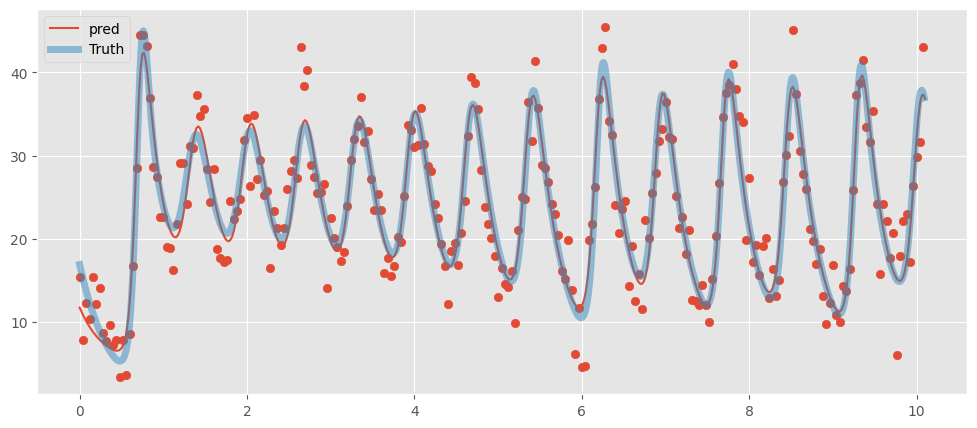

In [175]:
t_grid = jnp.linspace(0,10.1,500)
x_pred = model.predict_state(t_grid)

for i in range(3):
    plt.figure(figsize=(12,5))
    plt.scatter(expdata.t_train,expdata.x_train[:,i])
    plt.plot(t_grid,x_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,i],lw = 5,alpha = 0.5,label = 'Truth')
    plt.legend()
    plt.show()

In [179]:
t_grid = jnp.linspace(0,10,500)

xdot_pred = model.traj_model.derivative(t_grid,model.z)
x_pred = model.predict_state(t_grid)
A = dynamics_model.feature_map(x_pred)

I = jnp.eye(A.shape[1])
refit_theta = jnp.linalg.solve(A.T@A + 0.1*I ,A.T@xdot_pred)

from pysindy import STLSQ,SR3,EnsembleOptimizer,SSR
stlsq = STLSQ(threshold = 0.5,alpha =100.,unbias = True)
optimizer = stlsq
# EnsembleOptimizer(
#     stlsq,library_ensemble=True,
#     bagging = True,
#     n_models = 5000,
#     n_candidates_to_drop=2
#     )
# optimizer = SSR(criteria = 'model_residual',kappa = 0.1,alpha = 0.01)
optimizer.fit(A,xdot_pred)
refit_theta = jnp.array(optimizer.coef_).T

model.print(refit_theta)

(x)' = -12.296 x + 12.940 y
(y)' = 26.836 x + -0.757 y + -0.959 x z
(z)' = -24.749 1 + -1.151 z + 0.726 y^2


In [180]:
jnp.mean((dynamics_model.predict(expdata.x_test,refit_theta) - expdata.x_dot_test)**2)/jnp.var(expdata.x_dot_test)

Array(0.04903383, dtype=float64)